In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC, SparseCategoricalAccuracy
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import movmus as mm

import json
import os

# task context model

### opening and transforming metadata

In [10]:
train_labels, val_labels, test_labels = mm.load_data_npz('labels.npz')

shape of training data: (2720, 2)
shape of validation data: (502, 2)
shape of test data: (661, 2)


#### context with shape

In [31]:
train_task_context = mm.load_metadata_npz('task_context_train.npz')
val_task_context = mm.load_metadata_npz('task_context_val.npz')
test_task_context = mm.load_metadata_npz('task_context_test.npz')

print('Context data shapes:', train_task_context.shape, val_task_context.shape, test_task_context.shape)

Context data shapes: (2720, 25) (502, 25) (661, 25)


In [32]:
train_task_context = train_task_context.iloc[:, 1:]
val_task_context = val_task_context.iloc[:, 1:]
test_task_context = test_task_context.iloc[:, 1:]
print('Context data shapes:', train_task_context.shape, val_task_context.shape, test_task_context.shape)

Context data shapes: (2720, 24) (502, 24) (661, 24)


#### context without shape

In [14]:
train_task_context = mm.load_metadata_npz('task_no_shape_context_train.npz')
val_task_context = mm.load_metadata_npz('task_no_shape_context_val.npz')
test_task_context = mm.load_metadata_npz('task_no_shape_context_test.npz')

print('Context data shapes:', train_task_context.shape, val_task_context.shape, test_task_context.shape)

Context data shapes: (2720, 6) (502, 6) (661, 6)


In [15]:
train_task_context

,WEIGHT,SPAN_1,SPAN_2,TASK_HEIGHT_1.0,TASK_HEIGHT_2.0,TASK_HEIGHT_3.0
0,461.5,75.0,0.0,1.0,0.0,0.0
1,461.5,75.0,0.0,0.0,1.0,0.0
2,915.0,100.0,0.0,1.0,0.0,0.0
3,915.0,100.0,0.0,0.0,1.0,0.0
4,713.0,74.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
3878,75.5,25.0,0.0,0.0,1.0,0.0
3879,228.0,78.0,11.0,0.0,1.0,0.0
3880,0.0,5.0,6.0,0.0,1.0,0.0
3881,22.7,15.0,0.0,0.0,1.0,0.0


#### subject context 

In [7]:
train_subject_context = mm.load_metadata_npz('subject_context_train.npz')
val_subject_context = mm.load_metadata_npz('subject_context_val.npz')
test_subject_context = mm.load_metadata_npz('subject_context_test.npz')

print('Context data shapes:', train_subject_context.shape, val_subject_context.shape, test_subject_context.shape)

Context data shapes: (2720, 6) (502, 6) (661, 6)


In [8]:
train_subject_context = train_subject_context.iloc[:, 1:]
val_subject_context = val_subject_context.iloc[:, 1:]
test_subject_context = test_subject_context.iloc[:, 1:]
print('Context data shapes:', train_subject_context.shape, val_subject_context.shape, test_subject_context.shape)

Context data shapes: (2720, 5) (502, 5) (661, 5)


### model parameters

In [38]:
batch_size = 68
epochs = 300


In [39]:
# Define the learning rate schedule
initial_learning_rate = 0.001
decay_steps = 12000
print("Decay steps:", decay_steps)
alpha = 0.01 

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=alpha
)

Decay steps: 12000


In [40]:
from tensorflow.keras.callbacks import Callback

class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f" - lr: {lr}")

DEFINING THE ENTRIES

In [41]:
#DATA CONTEXT
X_trainContext = train_task_context.to_numpy()
print(' context shape: ' + str(X_trainContext.shape))

X_valContext = val_task_context.to_numpy()
print(' val context shape: ' + str(X_valContext.shape))
print('')
#LABELS
y_trainEMG = train_labels
y_valEMG = val_labels
print('emg labels shape: ' + str(y_trainEMG.shape))
print('emg val labels shape: ' + str(y_valEMG.shape))


 context shape: (2720, 24)
 val context shape: (502, 24)

emg labels shape: (2720, 2)
emg val labels shape: (502, 2)


### model creation

Name of the model:
- S_C : subject context
- T_C : task context

'+'

- CUSTOM : from parent EMG model M_20
- BASE : from parent EMG model M_28

'+'

- Model number


In [42]:
model_name = 'BASE_TASK_CONTEXT_NO_EMG_bn'
model_folder = '.\\MODELS_TC'
plot_folder = '.\\PLOTS_TC'


In [49]:
model_name = 'BASE_SUBJ_CONTEXT_NO_EMG'
model_folder = '.\\MODELS_SC'
plot_folder = '.\\PLOTS_SC'


In [43]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, 
    Dropout, Dense, Input, concatenate
)
from tensorflow.keras.models import Model

model = Sequential([
    # Layer 1
    tf.keras.layers.Dense(64, activation='relu', input_shape=(24,)),
    #tf.keras.layers.Dense(64, activation='relu', input_shape=(24,)),

    # Layer 2
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    # Exit layer
    tf.keras.layers.Dense(2, activation='softmax')
])




In [44]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=['accuracy', 'Precision', 'Recall', 'AUC'] 
)

In [45]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,874 (15.13 KB)

 Trainable params: 3,810 (14.88 KB)

 Non-trainable params: 64 (256.00 B)

### training

In [46]:
start_time = time.time()
history = model.fit(
    x=[X_trainContext],  # Input data: EMG and context
    y=y_trainEMG,                    # Labels
    validation_data=([X_valContext], y_valEMG),  # Validation data
    epochs=epochs,                        # Adjust based on your needs
    batch_size=batch_size,                    # Adjust based on your memory limits
    callbacks=[
        LearningRateLogger()#,                       
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)
end_time = time.time()

Epoch 1/300


30/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6495 - Precision: 0.6147 - Recall: 0.6147 - accuracy: 0.6147 - loss: 0.7245  - lr: 0.0009999729227274656
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.6745 - Precision: 0.6364 - Recall: 0.6364 - accuracy: 0.6364 - loss: 0.7044 - val_AUC: 0.6821 - val_Precision: 0.6116 - val_Recall: 0.6116 - val_accuracy: 0.6116 - val_loss: 0.7330
Epoch 2/300
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8460 - Precision: 0.7999 - Recall: 0.7999 - accuracy: 0.7999 - loss: 0.5416  - lr: 0.0009998914320021868
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8429 - Precision: 0.7937 - Recall: 0.7937 - accuracy: 0.7937 - loss: 0.5396 - val_AUC: 0.8374 - val_Precision: 0.7709 - val_Recall: 0.7709 - val_accuracy: 0.7709 - val_loss: 0.5634
Epoch 3/300
31/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8546 - Precision: 0.7660 - Recall: 0.7660 - accuracy: 0.7660 - loss: 0.5001  - lr: 0.0009997556917369366
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8586 - Pre

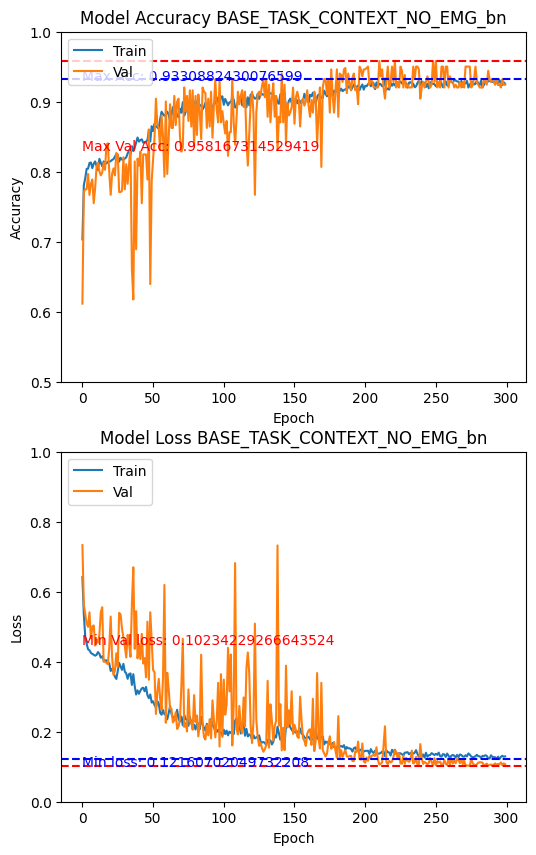

In [47]:
fig, axs = plt.subplots(2,1, figsize=(6, 10))
    
# Subplot 1: Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy ' + model_name)

axs[0].axhline(y=max(history.history['accuracy']), color='b', linestyle='--')  # Add horizontal line at y=0.75
axs[0].text(0,0.93, f'Max Acc: {max(history.history["accuracy"])}', color='b')  # Add text annotation with the max value

axs[0].axhline(y=max(history.history['val_accuracy']), color='r', linestyle='--')  # Add horizontal line at y=0.75
axs[0].text(0,0.83, f'Max Val Acc: {max(history.history["val_accuracy"])}', color='red')  # Add text annotation with the max value
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[0].set_ylim(0.5, 1)

# Subplot 2: Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss ' + model_name)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')
axs[1].set_ylim(0, 1)

axs[1].axhline(y=min(history.history['val_loss']), color='r', linestyle='--')  # Add horizontal line at y=0.75
axs[1].text(0,0.45, f'Min Val loss: {min(history.history["val_loss"])}', color='red')  # Add text annotation with the max value

axs[1].axhline(y=min(history.history['loss']), color='b', linestyle='--')  # Add horizontal line at y=0.75
axs[1].text(0,0.1, f'Min loss: {min(history.history["loss"])}', color='b')  # Add text annotation with the max value

# Save the figure with subplots
plt.savefig(f'{plot_folder}\\ACC_LOSS_{model_name}.png')

# Show the plot
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


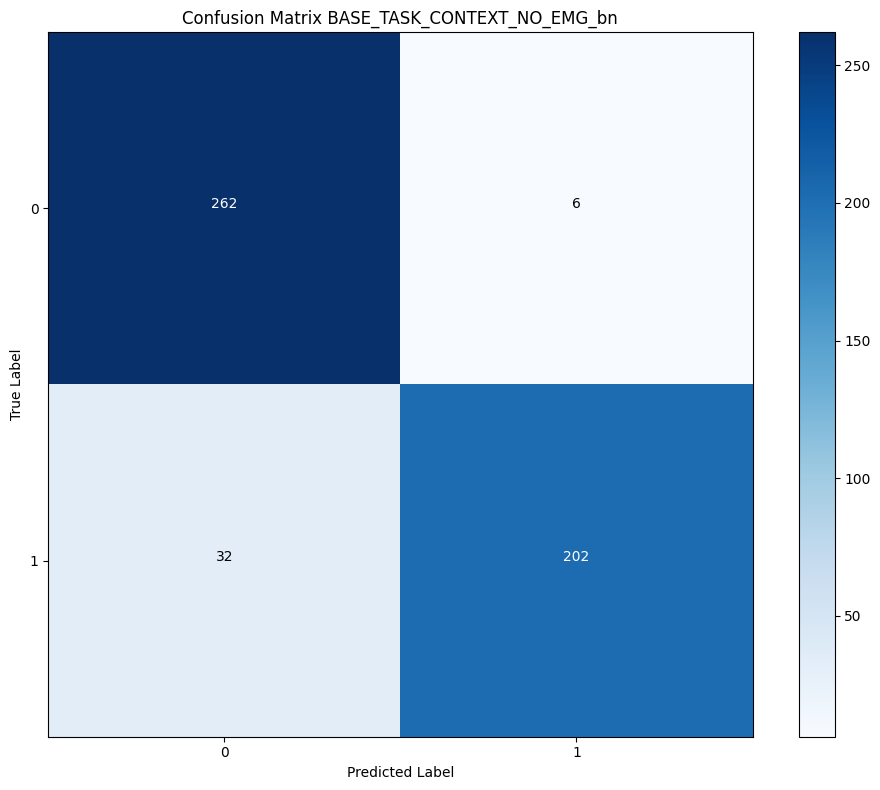

In [48]:
#import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

# Assuming y_val is one-hot encoded, convert it back to class labels
y_true_classes = np.argmax(y_valEMG, axis=1)

# Make predictions on the validation set
y_pred = model.predict([X_valContext])

# Convert predictions from sigmoid output to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cmap = plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix ' + model_name)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true_classes)))  # this adapts to the number of classes dynamically
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Labeling the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig(f'{plot_folder}\\CM_{model_name}.png')

plt.show()


In [49]:
mm.save_model(model, model_folder, model_name)


Model saved to .\MODELS_TC\BASE_TASK_CONTEXT_NO_EMG_bn.keras


In [50]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")
print(f"Training time: {training_time/60} minutes")
# Convert the history object to a dictionary
history_dict = history.history

# Add the training time to the dictionary
history_dict['training_time'] = training_time
history_dict['model'] = model_name
history_dict['batch_size'] = batch_size
history_dict['epochs'] = epochs
history_dict['learning_rate'] = initial_learning_rate
history_dict['decay_steps'] = decay_steps
history_dict['alpha'] = alpha
history_dict['loss_function'] = 'binary_crossentropy'
history_dict['optimizer'] = 'Adam'

# Save the dictionary to a JSON file

mm.save_history(history_dict, model_folder, model_name)

Training time: 39.29209065437317 seconds
Training time: 0.6548681775728862 minutes
History saved to .\MODELS_TC\BASE_TASK_CONTEXT_NO_EMG_bn_history.json


In [51]:

print('output shape')
print(y_pred.shape)
print('output')
print(y_pred)

output shape
(502, 2)
output
[[1.1944661e-07 9.9999988e-01]
 [1.6483551e-04 9.9983513e-01]
 [3.2736747e-07 9.9999964e-01]
 ...
 [9.9999630e-01 3.6750196e-06]
 [9.9999285e-01 7.1592417e-06]
 [9.9998462e-01 1.5384932e-05]]
